## Predicting PV plant power for controls feedback optimization ##
Brooke Stanislawski

Requirements:
- `conda` hercules environment (with `pvlib` installed)
- `.json` file defining the PV system design

Notes:
- Developed for the location of the AWAKEN/ARM field experiment in Oklahoma, but can change the location in the inputs. However, results appear to remain constant as long as timestamp is during the day (based on minimal testing.)

In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PySAM.Pvsamv1 as pvsam

In [26]:
# ARM location - Great Plains, Oklahoma
lat = 39.7442
lon = -105.1778
elev = 1829

# Phoenix, AZ
# lat = 33.481136
# lon = -112.078232
# elev = 331

In [27]:
# load system design info
system_info_file_name = '/Users/bstanisl/hercules-pysam/hercules/example_case_folders/07_amr_wind_standin_and_solar_pysam/100MW_1axis_pvsamv1.json'
with open(system_info_file_name, "r") as f:
      model_params = json.load(f)
sys_design = {
    "ModelParams": model_params,
}

model_params = sys_design["ModelParams"]


In [28]:
# create dataframe with parametric sweep of variables
air_temps = np.linspace(-20, 40, 60) # 60) # degrees C # captures range in TMY from NSRDB
poas = np.linspace(0., 1200., 60) # 60) # irradiance W/m2 # captures range in TMY from NSRDB

#generate dictionary of parametric sweep
air_temp_list = []
poa_list = []
for a,air_temp in enumerate(air_temps):
    for i,poa in enumerate(poas):
        air_temp_list.append(air_temp)
        poa_list.append(poa)


In [29]:
dict = {
    "Timestamp": ['2018-05-10 12:31:00+00:00'] * len(poa_list),
    "SRRL BMS Wind Speed at 19' (m/s)": [0.4400002620664621] * len(poa_list),
    "SRRL BMS Dry Bulb Temperature (°C)": air_temp_list,
    "poa": poa_list,
}
data = pd.DataFrame(dict)
data["Timestamp"] = pd.DatetimeIndex(
        pd.to_datetime(data["Timestamp"], format="ISO8601", utc=True)
        )
data = data.set_index("Timestamp")

tz = data.index[0].utcoffset().total_seconds() / 60 / 60

data.head()

,SRRL BMS Wind Speed at 19' (m/s),SRRL BMS Dry Bulb Temperature (°C),poa
Timestamp,,,
2018-05-10 12:31:00+00:00,0.44,-20.0,0.000000
2018-05-10 12:31:00+00:00,0.44,-20.0,133.333333
2018-05-10 12:31:00+00:00,0.44,-20.0,266.666667
2018-05-10 12:31:00+00:00,0.44,-20.0,400.000000
2018-05-10 12:31:00+00:00,0.44,-20.0,533.333333


In [30]:
system_model = pvsam.new()
system_model.AdjustmentFactors.constant = 0
system_model.AdjustmentFactors.dc_constant = 0    

for k, v in model_params.items():
    try:
        system_model.value(k, v)
    except Exception:
        print(k)

#initialize outputs
ac_list = [] # np.zeros((len(air_temps), len(poas)))
dc_list = [] #np.zeros((len(air_temps), len(poas)))
dni_list = [] #np.zeros((len(air_temps), len(poas)))

# iterate through parameter sweep, keeping other variables constant
for index, row in data.iterrows():
    weather_data = np.array(
        [
            index.year,
            index.month,
            index.day,
            index.hour,
            index.minute,
            row["SRRL BMS Wind Speed at 19' (m/s)"],
            row["SRRL BMS Dry Bulb Temperature (°C)"],
            row["poa"],
        ]
    )

    solar_resource_data = {
        "tz": tz,  # timezone
        "elev": elev,  # elevation
        "lat": lat,  # latitude
        "lon": lon,  # longitude
        "year":   tuple([weather_data[0]]),  # year
        "month":  tuple([weather_data[1]]),  # month
        "day":    tuple([weather_data[2]]),  # day
        "hour":   tuple([weather_data[3]]),  # hour
        "minute": tuple([weather_data[4]]),  # minute
        "poa":    tuple([weather_data[7]]),  # poa irradiance
        "wspd":   tuple([weather_data[5]]),  # windspeed
        "tdry":   tuple([weather_data[6]]),  # dry bulb temperature
    }

    # if row['poa'] == data.poa[0]:
    #     print(solar_resource_data)

    system_model.SolarResource.irrad_mode = 3
    system_model.SolarResource.assign({"solar_resource_data": solar_resource_data})
    system_model.AdjustmentFactors.assign({"constant": 0})
    system_model.execute()
    out = system_model.Outputs.export()

    ac_list.append(out["gen"][0]) # kW # / 1000  
    dc_list.append(out["dc_net"][0]) # kW # / 1000
    dni_list.append(out["dn"][0])

ac = np.array(ac_list).reshape((len(air_temps), len(poas)))
dc = np.array(dc_list).reshape((len(air_temps), len(poas)))
dni = np.array(dni_list).reshape((len(air_temps), len(poas)))

subarray1_shading_en_string_option
subarray1_shading_en_timestep
subarray1_shading_en_diff
enable_subhourly_clipping
{'tz': 0.0, 'elev': 1829, 'lat': 39.7442, 'lon': -105.1778, 'year': (2018.0,), 'month': (5.0,), 'day': (10.0,), 'hour': (12.0,), 'minute': (31.0,), 'poa': (0.0,), 'wspd': (0.4400002620664621,), 'tdry': (-20.0,)}


/var/folders/mc/259lhqnn0pvc43fwg1cgzg00jh8n6f/T/ipykernel_54509/199789373.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row['poa'] == data.poa[0]:


{'tz': 0.0, 'elev': 1829, 'lat': 39.7442, 'lon': -105.1778, 'year': (2018.0,), 'month': (5.0,), 'day': (10.0,), 'hour': (12.0,), 'minute': (31.0,), 'poa': (0.0,), 'wspd': (0.4400002620664621,), 'tdry': (-8.0,)}
{'tz': 0.0, 'elev': 1829, 'lat': 39.7442, 'lon': -105.1778, 'year': (2018.0,), 'month': (5.0,), 'day': (10.0,), 'hour': (12.0,), 'minute': (31.0,), 'poa': (0.0,), 'wspd': (0.4400002620664621,), 'tdry': (4.0,)}
{'tz': 0.0, 'elev': 1829, 'lat': 39.7442, 'lon': -105.1778, 'year': (2018.0,), 'month': (5.0,), 'day': (10.0,), 'hour': (12.0,), 'minute': (31.0,), 'poa': (0.0,), 'wspd': (0.4400002620664621,), 'tdry': (16.0,)}
{'tz': 0.0, 'elev': 1829, 'lat': 39.7442, 'lon': -105.1778, 'year': (2018.0,), 'month': (5.0,), 'day': (10.0,), 'hour': (12.0,), 'minute': (31.0,), 'poa': (0.0,), 'wspd': (0.4400002620664621,), 'tdry': (28.0,)}
{'tz': 0.0, 'elev': 1829, 'lat': 39.7442, 'lon': -105.1778, 'year': (2018.0,), 'month': (5.0,), 'day': (10.0,), 'hour': (12.0,), 'minute': (31.0,), 'poa': (0

Results remain mostly constant with changes in location (as long as timestamp is during the day)

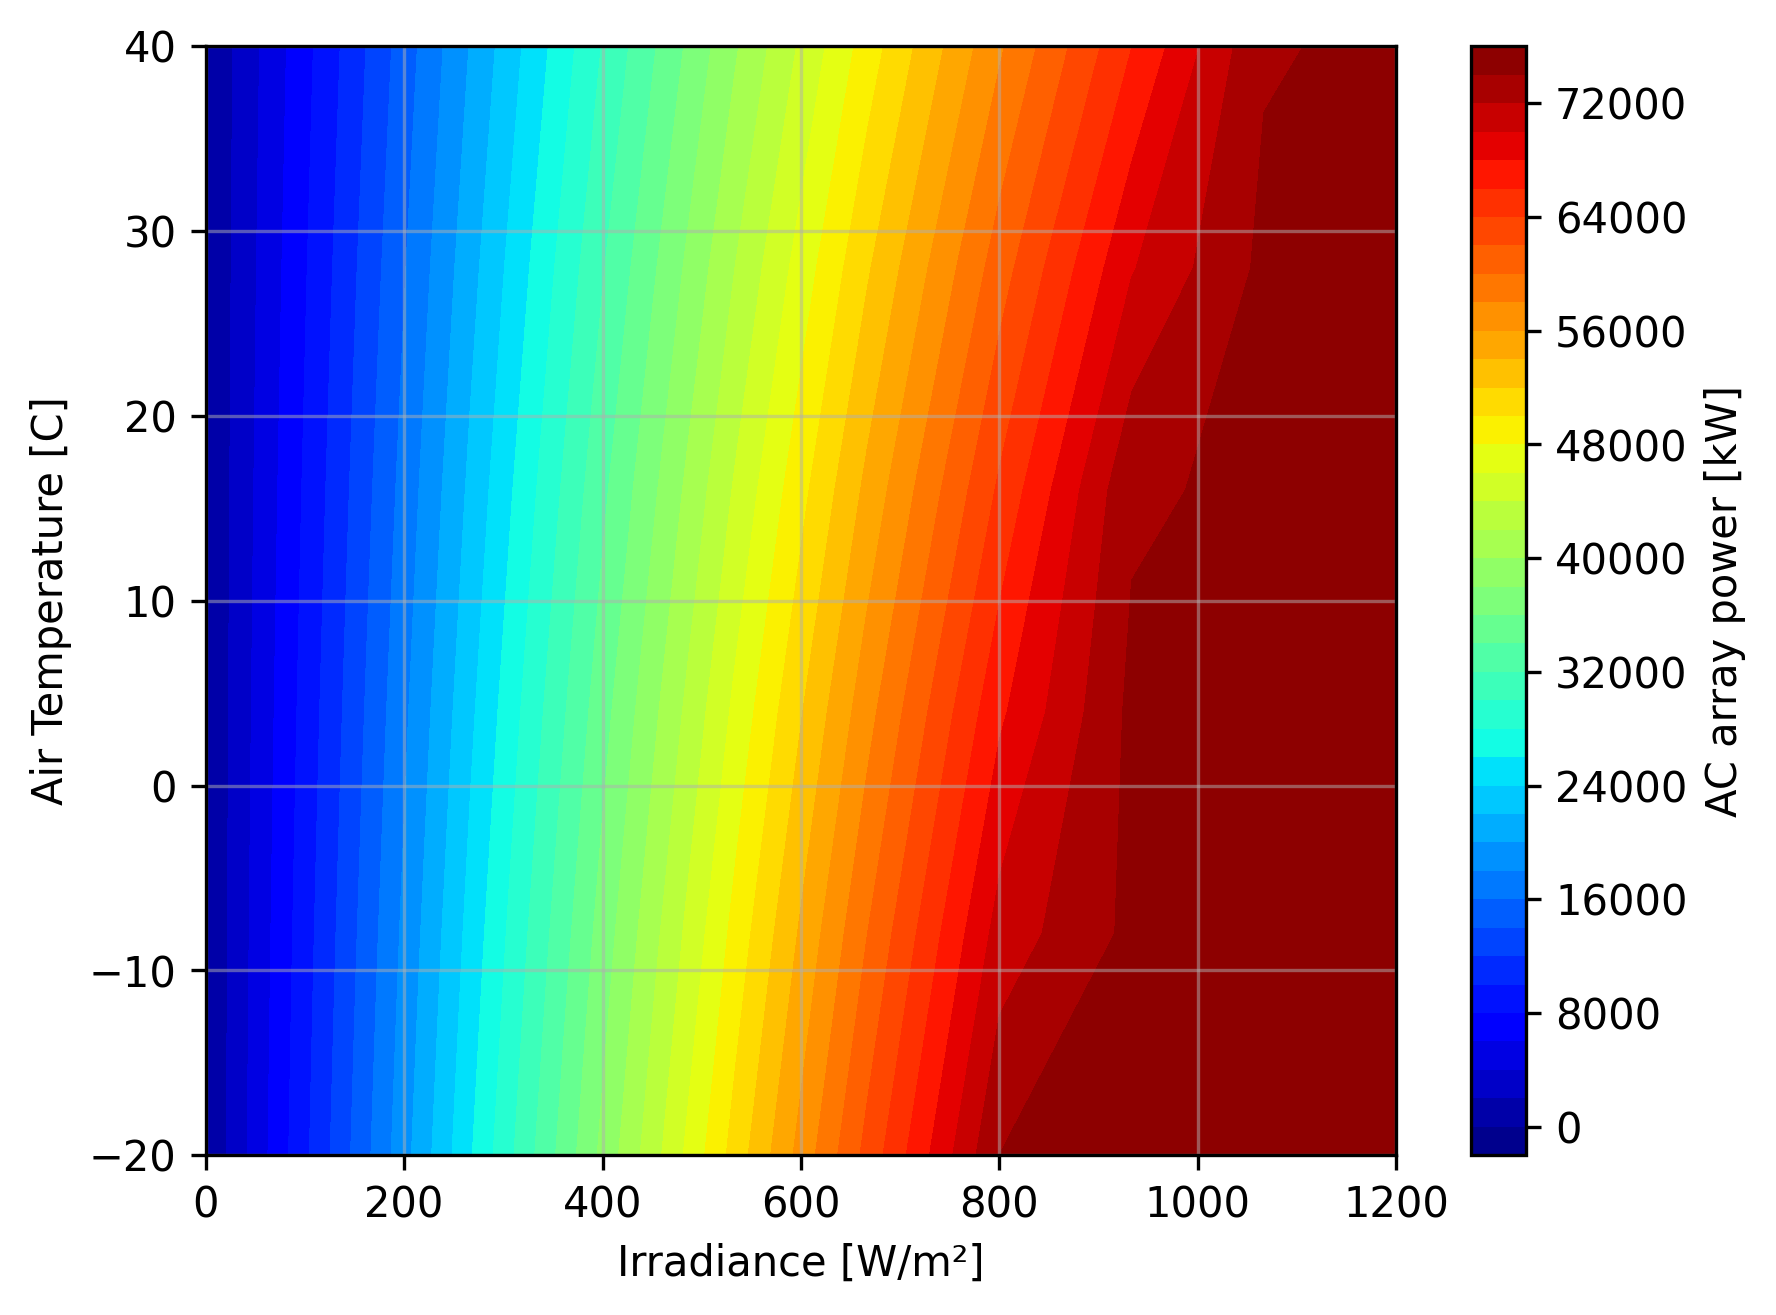

In [33]:
# contour plot
plt.figure(dpi=300)
plt.contourf(poas, air_temps, ac, 40, cmap='jet')

plt.colorbar(label='AC array power [kW]', ax=plt.gca())
plt.grid(alpha=0.5)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Air Temperature [C]')
plt.show()

In [32]:
# create dictionary of data to export
data_export = np.zeros((len(poas),len(air_temps)+2))
data_export[:,0] = poas
data_export[:,1] = air_temps
data_export[:,2:] = ac

np.save('data_export.npy', data_export)

ValueError: could not broadcast input array from shape (6,) into shape (10,)

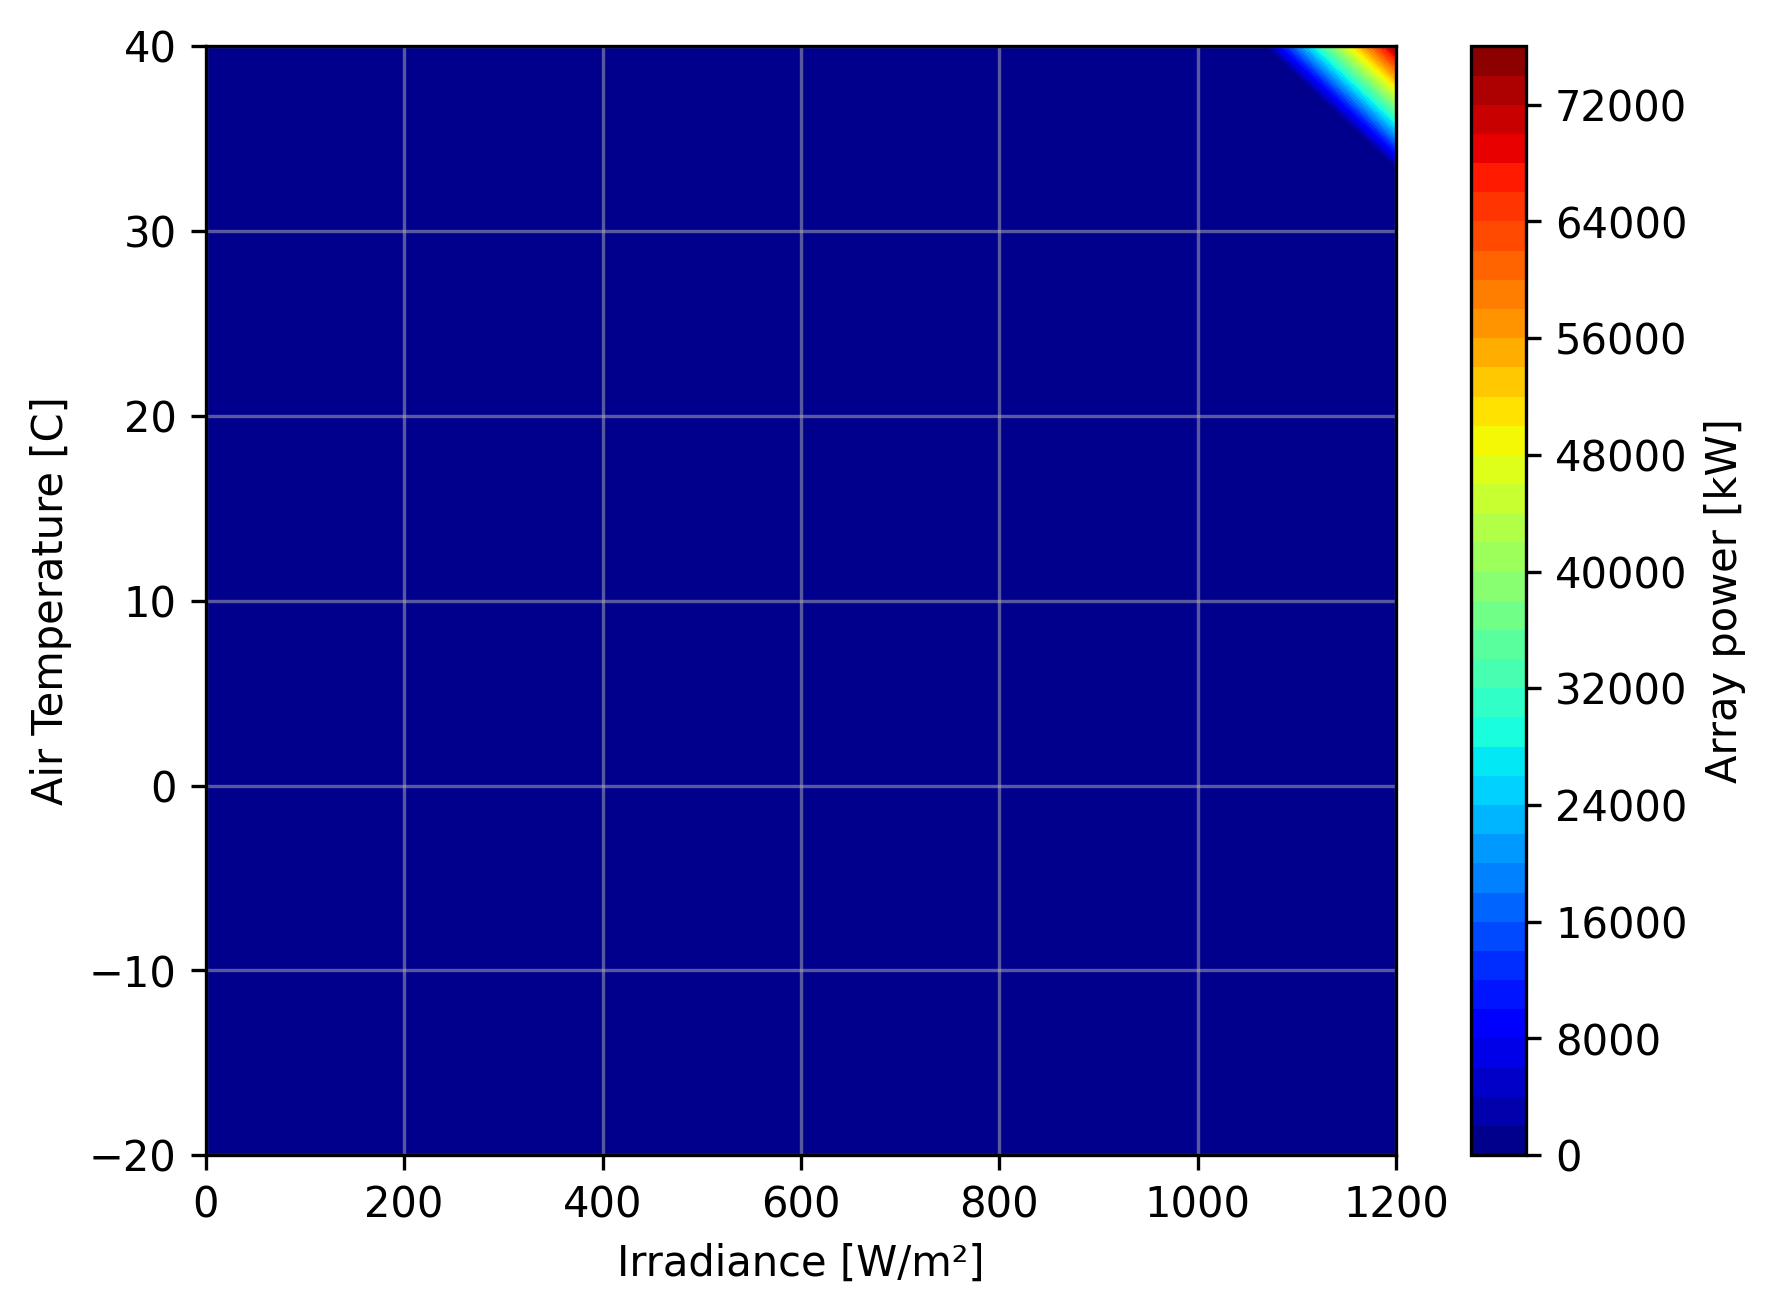

In [ ]:
data_import = np.load('data_export.npy')

xt = data_export[:,0]
yt = data_export[:,1]
zt = data_export[:,2:]

plt.figure(dpi=300)
plt.contourf(xt, yt, zt, 40, cmap='jet')

plt.colorbar(label='Array power [kW]', ax=plt.gca())
plt.grid(alpha=0.5)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Air Temperature [C]')
plt.show()